# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

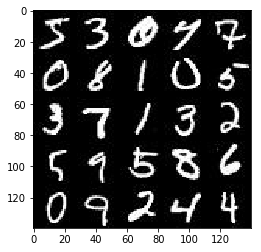

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

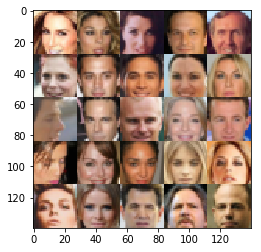

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/eduardo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flatten = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        outs = tf.tanh(logits)
        
        return outs

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                     logits=d_logits_real, 
                                                     labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                    logits=d_logits_fake, 
                                                    labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                    logits=d_logits_fake, 
                                                    labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
                            learning_rate,
                            beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
                        learning_rate,
                        beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
                                    img_width, 
                                    img_height, 
                                    img_channels,
                                    z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3846... Generator Loss: 6.6513
Epoch 1/2... Discriminator Loss: 2.6094... Generator Loss: 6.6603
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 0.5346
Epoch 1/2... Discriminator Loss: 0.5705... Generator Loss: 1.4199
Epoch 1/2... Discriminator Loss: 3.0839... Generator Loss: 0.1272
Epoch 1/2... Discriminator Loss: 0.5316... Generator Loss: 2.2151
Epoch 1/2... Discriminator Loss: 1.1337... Generator Loss: 6.6030
Epoch 1/2... Discriminator Loss: 0.1609... Generator Loss: 4.2472
Epoch 1/2... Discriminator Loss: 0.1186... Generator Loss: 2.7879
Epoch 1/2... Discriminator Loss: 0.2061... Generator Loss: 2.0927


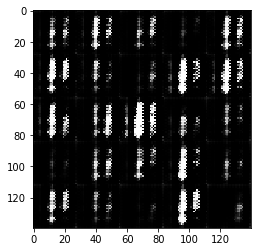

Epoch 1/2... Discriminator Loss: 0.6819... Generator Loss: 3.5504
Epoch 1/2... Discriminator Loss: 0.6391... Generator Loss: 2.2097
Epoch 1/2... Discriminator Loss: 0.2212... Generator Loss: 2.1945
Epoch 1/2... Discriminator Loss: 0.5330... Generator Loss: 2.1639
Epoch 1/2... Discriminator Loss: 0.3820... Generator Loss: 3.0733
Epoch 1/2... Discriminator Loss: 0.2403... Generator Loss: 4.8224
Epoch 1/2... Discriminator Loss: 0.2335... Generator Loss: 3.5637
Epoch 1/2... Discriminator Loss: 7.4275... Generator Loss: 12.1223
Epoch 1/2... Discriminator Loss: 0.3591... Generator Loss: 1.8712
Epoch 1/2... Discriminator Loss: 0.9781... Generator Loss: 7.4641


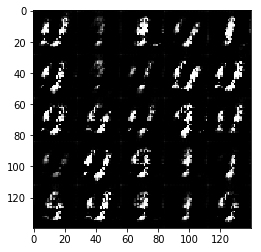

Epoch 1/2... Discriminator Loss: 0.3460... Generator Loss: 2.3264
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 0.9394
Epoch 1/2... Discriminator Loss: 4.8666... Generator Loss: 10.6367
Epoch 1/2... Discriminator Loss: 0.5717... Generator Loss: 2.6701
Epoch 1/2... Discriminator Loss: 0.3646... Generator Loss: 1.6895
Epoch 1/2... Discriminator Loss: 0.5185... Generator Loss: 3.0923
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 0.4114... Generator Loss: 2.2812
Epoch 1/2... Discriminator Loss: 0.5505... Generator Loss: 5.0898
Epoch 1/2... Discriminator Loss: 0.7132... Generator Loss: 2.1697


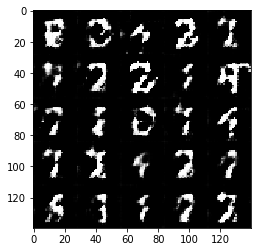

Epoch 1/2... Discriminator Loss: 0.1679... Generator Loss: 3.6907
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 0.6371... Generator Loss: 3.6490
Epoch 1/2... Discriminator Loss: 0.3963... Generator Loss: 2.0535
Epoch 1/2... Discriminator Loss: 0.5759... Generator Loss: 1.6343
Epoch 1/2... Discriminator Loss: 0.4755... Generator Loss: 2.3216
Epoch 1/2... Discriminator Loss: 0.6883... Generator Loss: 1.5609
Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 2.9067
Epoch 1/2... Discriminator Loss: 1.3136... Generator Loss: 1.3901
Epoch 1/2... Discriminator Loss: 2.1266... Generator Loss: 0.2837


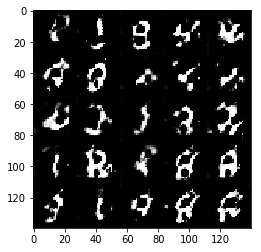

Epoch 1/2... Discriminator Loss: 0.7635... Generator Loss: 3.3786
Epoch 1/2... Discriminator Loss: 1.0810... Generator Loss: 2.7895
Epoch 1/2... Discriminator Loss: 0.6934... Generator Loss: 1.1334
Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 0.6369
Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 1.4098
Epoch 1/2... Discriminator Loss: 0.5187... Generator Loss: 2.0504
Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 2.3749
Epoch 1/2... Discriminator Loss: 1.2194... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 0.9487
Epoch 1/2... Discriminator Loss: 0.4350... Generator Loss: 2.5179


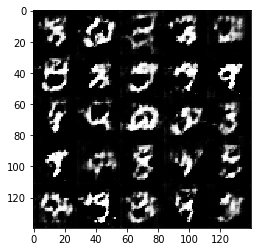

Epoch 1/2... Discriminator Loss: 1.0543... Generator Loss: 0.9201
Epoch 1/2... Discriminator Loss: 0.8034... Generator Loss: 1.1618
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 3.0162
Epoch 1/2... Discriminator Loss: 1.7566... Generator Loss: 0.4138
Epoch 1/2... Discriminator Loss: 0.7873... Generator Loss: 1.0260
Epoch 1/2... Discriminator Loss: 0.7095... Generator Loss: 1.4951
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.7159
Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 0.9388
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 2.1586
Epoch 1/2... Discriminator Loss: 1.0498... Generator Loss: 1.2386


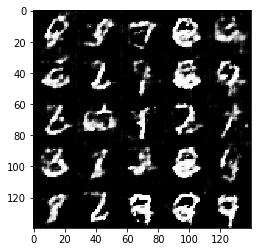

Epoch 1/2... Discriminator Loss: 0.7213... Generator Loss: 1.8154
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 0.6603
Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 2.4192
Epoch 1/2... Discriminator Loss: 0.7297... Generator Loss: 1.0876
Epoch 1/2... Discriminator Loss: 1.0638... Generator Loss: 3.1268
Epoch 1/2... Discriminator Loss: 0.6916... Generator Loss: 1.1016
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 0.9109
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 0.5790
Epoch 1/2... Discriminator Loss: 0.6141... Generator Loss: 1.4257
Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 1.8527


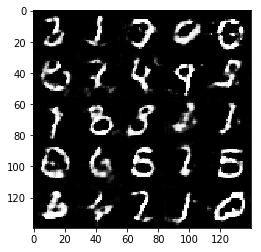

Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 0.7867
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 3.5587
Epoch 1/2... Discriminator Loss: 0.8340... Generator Loss: 2.9162
Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 1.0182
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 0.7007
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 0.9378
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 0.5894
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 0.7635


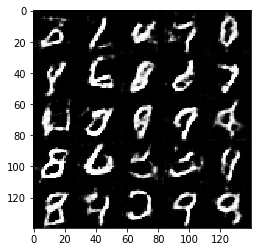

Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 0.7734
Epoch 1/2... Discriminator Loss: 0.8623... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 1.3572
Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 0.7142... Generator Loss: 1.1987
Epoch 1/2... Discriminator Loss: 1.6305... Generator Loss: 0.5767
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 1.1056
Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 1.0372
Epoch 1/2... Discriminator Loss: 1.5853... Generator Loss: 0.4368
Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 1.4575


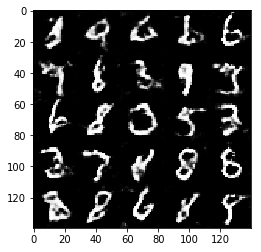

Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.4633
Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 1.3837
Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 0.6267... Generator Loss: 1.3182
Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 1.8128
Epoch 2/2... Discriminator Loss: 1.0978... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 1.6097... Generator Loss: 0.5999
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 0.9992
Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 1.7060
Epoch 2/2... Discriminator Loss: 1.0916... Generator Loss: 0.6220


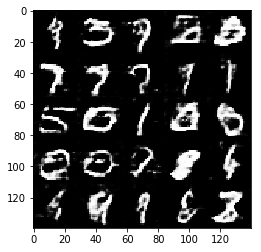

Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 0.9924
Epoch 2/2... Discriminator Loss: 0.8023... Generator Loss: 1.2492
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 1.3388
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 1.6150... Generator Loss: 0.3399
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 0.7452
Epoch 2/2... Discriminator Loss: 1.4373... Generator Loss: 0.4018
Epoch 2/2... Discriminator Loss: 0.8906... Generator Loss: 1.0016
Epoch 2/2... Discriminator Loss: 1.5403... Generator Loss: 0.4283
Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 0.5374


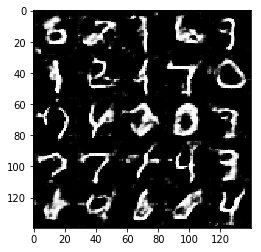

Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 0.8181... Generator Loss: 1.1014
Epoch 2/2... Discriminator Loss: 0.8149... Generator Loss: 1.1101
Epoch 2/2... Discriminator Loss: 1.0919... Generator Loss: 2.3322
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 0.7611
Epoch 2/2... Discriminator Loss: 1.6070... Generator Loss: 0.3216
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 0.4821
Epoch 2/2... Discriminator Loss: 1.1496... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 1.0233... Generator Loss: 0.6172


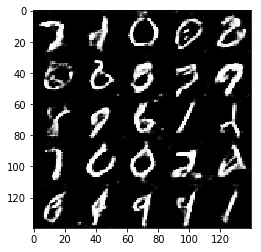

Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 0.5922
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 1.2103
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.3017
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 1.5354
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 0.6670
Epoch 2/2... Discriminator Loss: 1.4870... Generator Loss: 0.5022
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 0.8825
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 3.0919
Epoch 2/2... Discriminator Loss: 0.7686... Generator Loss: 1.3621


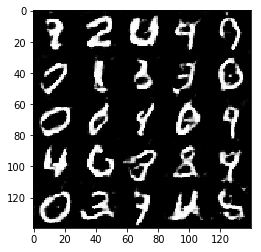

Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 0.5065
Epoch 2/2... Discriminator Loss: 3.7415... Generator Loss: 4.1221
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 1.0437
Epoch 2/2... Discriminator Loss: 1.7883... Generator Loss: 2.8998
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.5586
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 1.1660... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 1.2028
Epoch 2/2... Discriminator Loss: 0.6331... Generator Loss: 1.3235
Epoch 2/2... Discriminator Loss: 1.7567... Generator Loss: 2.6482


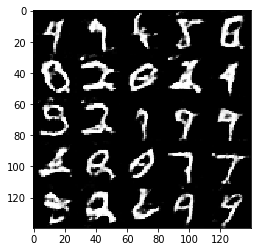

Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 0.9365
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 1.2650
Epoch 2/2... Discriminator Loss: 0.7626... Generator Loss: 1.6807
Epoch 2/2... Discriminator Loss: 0.8161... Generator Loss: 0.8942
Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.5519
Epoch 2/2... Discriminator Loss: 1.5317... Generator Loss: 0.3484
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 0.7475
Epoch 2/2... Discriminator Loss: 0.9749... Generator Loss: 1.6007
Epoch 2/2... Discriminator Loss: 1.4953... Generator Loss: 0.4056
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 0.9799


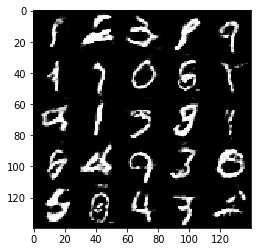

Epoch 2/2... Discriminator Loss: 0.8542... Generator Loss: 1.0188
Epoch 2/2... Discriminator Loss: 0.7023... Generator Loss: 1.5465
Epoch 2/2... Discriminator Loss: 0.3347... Generator Loss: 2.5609
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 2.1794
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 0.7446
Epoch 2/2... Discriminator Loss: 1.4380... Generator Loss: 0.4272
Epoch 2/2... Discriminator Loss: 1.6121... Generator Loss: 0.3768
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 2.1830
Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 1.1082... Generator Loss: 1.7221


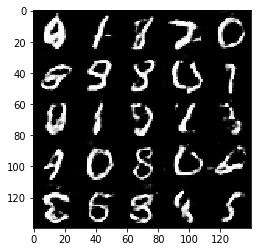

Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 0.7893
Epoch 2/2... Discriminator Loss: 0.6068... Generator Loss: 1.5330
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 0.4542
Epoch 2/2... Discriminator Loss: 0.6701... Generator Loss: 1.0967
Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 3.3233
Epoch 2/2... Discriminator Loss: 0.6700... Generator Loss: 1.1611
Epoch 2/2... Discriminator Loss: 0.8461... Generator Loss: 0.9993
Epoch 2/2... Discriminator Loss: 0.6186... Generator Loss: 1.6028
Epoch 2/2... Discriminator Loss: 1.0554... Generator Loss: 1.7630
Epoch 2/2... Discriminator Loss: 1.7048... Generator Loss: 0.3282


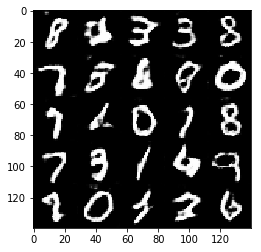

Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 0.3812
Epoch 2/2... Discriminator Loss: 1.5115... Generator Loss: 0.3628
Epoch 2/2... Discriminator Loss: 1.1139... Generator Loss: 0.6436
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.1636
Epoch 2/2... Discriminator Loss: 0.7490... Generator Loss: 2.2661
Epoch 2/2... Discriminator Loss: 0.6771... Generator Loss: 1.4269
Epoch 2/2... Discriminator Loss: 0.8893... Generator Loss: 0.9559
Epoch 2/2... Discriminator Loss: 1.6086... Generator Loss: 0.4307
Epoch 2/2... Discriminator Loss: 0.6412... Generator Loss: 2.2039
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 0.9833


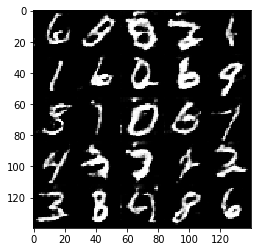

Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.9353
Epoch 2/2... Discriminator Loss: 1.2518... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 0.9674
Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 0.5309
Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 1.0084
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 1.9136
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.6674


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 6.5915
Epoch 1/1... Discriminator Loss: 0.3142... Generator Loss: 8.1550
Epoch 1/1... Discriminator Loss: 0.2998... Generator Loss: 4.6639
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 0.1256... Generator Loss: 2.7505
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 6.4114
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 0.0971... Generator Loss: 3.0904
Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 5.8997
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 3.0300


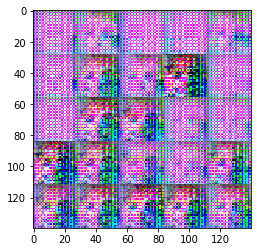

Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 8.0236
Epoch 1/1... Discriminator Loss: 3.2144... Generator Loss: 0.1763
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 5.7967
Epoch 1/1... Discriminator Loss: 0.0516... Generator Loss: 4.8022
Epoch 1/1... Discriminator Loss: 0.3320... Generator Loss: 1.7582
Epoch 1/1... Discriminator Loss: 0.1200... Generator Loss: 3.5965
Epoch 1/1... Discriminator Loss: 0.2799... Generator Loss: 2.3182
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 3.1326
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 0.1550... Generator Loss: 2.7159


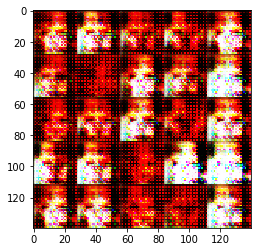

Epoch 1/1... Discriminator Loss: 0.2091... Generator Loss: 2.3036
Epoch 1/1... Discriminator Loss: 2.3488... Generator Loss: 0.2386
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 0.2143... Generator Loss: 1.9507
Epoch 1/1... Discriminator Loss: 0.0139... Generator Loss: 4.8128
Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 1.9949
Epoch 1/1... Discriminator Loss: 0.3373... Generator Loss: 2.2657
Epoch 1/1... Discriminator Loss: 0.0536... Generator Loss: 3.8759
Epoch 1/1... Discriminator Loss: 0.2980... Generator Loss: 1.5790
Epoch 1/1... Discriminator Loss: 0.0429... Generator Loss: 3.9217


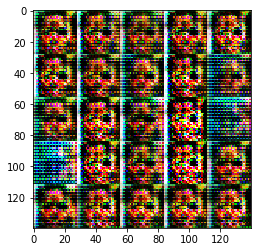

Epoch 1/1... Discriminator Loss: 0.0551... Generator Loss: 3.5275
Epoch 1/1... Discriminator Loss: 0.1211... Generator Loss: 2.4221
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 1.9879
Epoch 1/1... Discriminator Loss: 0.3298... Generator Loss: 2.1489
Epoch 1/1... Discriminator Loss: 1.9264... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.4604
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 2.1142
Epoch 1/1... Discriminator Loss: 0.6395... Generator Loss: 2.3099
Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 1.2231
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.1768


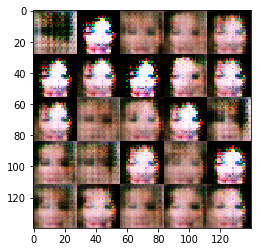

Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 2.1439
Epoch 1/1... Discriminator Loss: 1.8988... Generator Loss: 4.3366
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 2.6414
Epoch 1/1... Discriminator Loss: 0.6990... Generator Loss: 1.2760
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 0.4502... Generator Loss: 1.6837
Epoch 1/1... Discriminator Loss: 0.2685... Generator Loss: 1.9172
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 1.4260
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 3.0273
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.9603


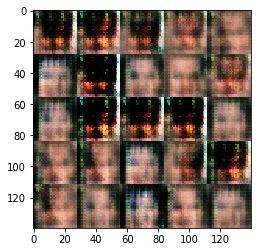

Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 2.2324
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 1.5909
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 0.3717... Generator Loss: 2.5042
Epoch 1/1... Discriminator Loss: 1.6490... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 2.8260... Generator Loss: 4.7946
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.8258


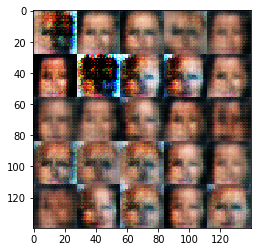

Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.1746
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 0.6563... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 1.3030
Epoch 1/1... Discriminator Loss: 2.7942... Generator Loss: 0.1071
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 2.3947
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 2.5991


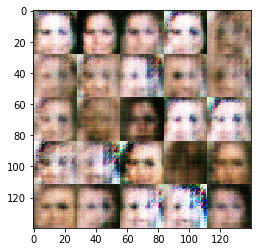

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.2692
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 2.5632
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.9133
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 1.5823
Epoch 1/1... Discriminator Loss: 0.6175... Generator Loss: 1.7802
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.5941


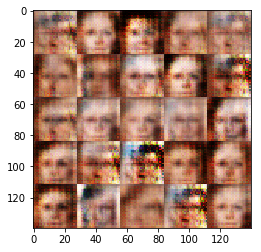

Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 3.1984
Epoch 1/1... Discriminator Loss: 2.4798... Generator Loss: 2.7854
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.3248
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 2.0787
Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 2.1509


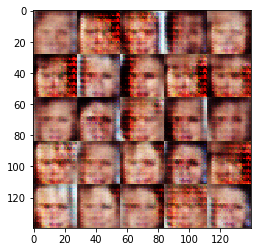

Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 2.5611
Epoch 1/1... Discriminator Loss: 2.3449... Generator Loss: 0.1698
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 1.5367
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 1.4859


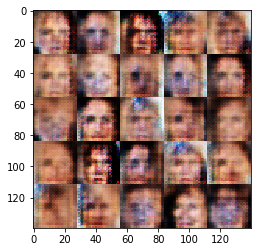

Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 3.4276
Epoch 1/1... Discriminator Loss: 1.8108... Generator Loss: 0.2427
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 2.0105... Generator Loss: 2.3976
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.9731
Epoch 1/1... Discriminator Loss: 0.2867... Generator Loss: 2.5516
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.8466


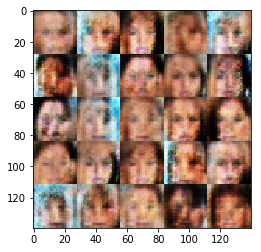

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 1.6073
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 2.1551
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.7367
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 2.0313
Epoch 1/1... Discriminator Loss: 0.4490... Generator Loss: 3.1363
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 1.6393
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.3251
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 1.1630


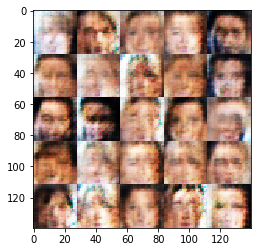

Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.8735
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.5709


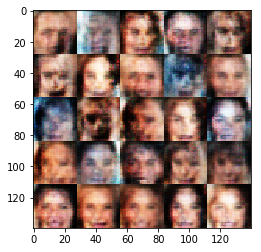

Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.4914
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 2.0714
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.0729


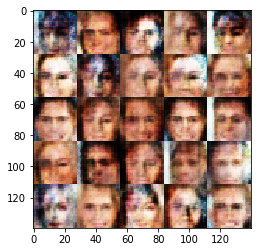

Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 2.9418
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.3309
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 0.7365... Generator Loss: 1.3901
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 1.4894


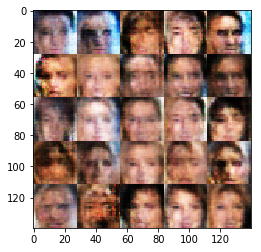

Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 2.3359
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.4393
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.7493
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.4325


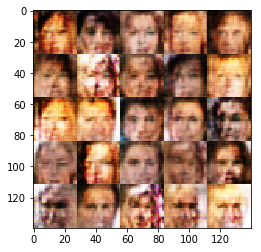

Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 0.3232
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 1.4757
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 1.8324
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 0.9844


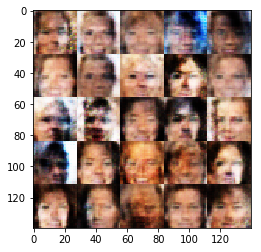

Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 3.1076
Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.2585


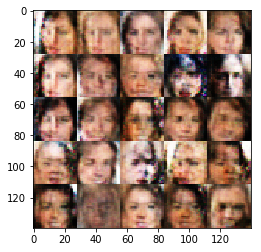

Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.7471
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.5947
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 1.6791
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.8183
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.4964


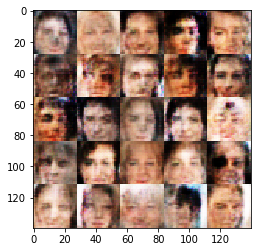

Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.1723
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.4119
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 0.9308


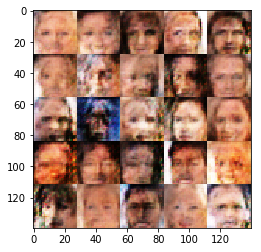

Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 1.5200
Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 1.1829
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.4880


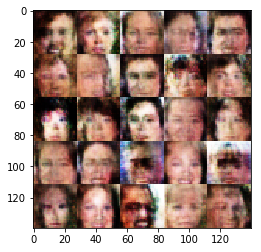

Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 1.8750
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.4846
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 1.5886
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 2.0231... Generator Loss: 2.3941
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 1.6741
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.7905


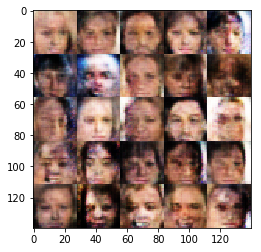

Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 3.1671
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.5166
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.3416
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.7675


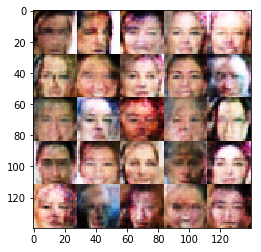

Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 2.0168
Epoch 1/1... Discriminator Loss: 0.5051... Generator Loss: 2.5007
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.3097
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 2.4021


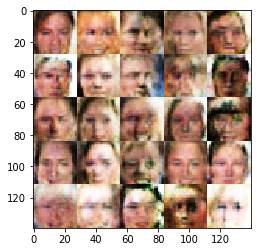

Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.7895
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.2836
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.5086
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 3.0365
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 1.4916
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.3597
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.0361


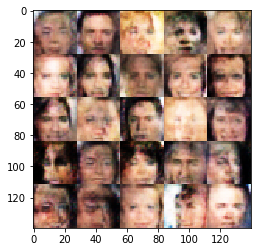

Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.0970
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.6029... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 2.3623
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.5805


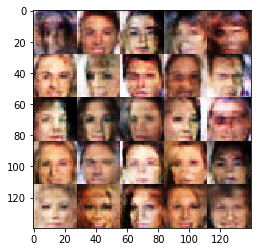

Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 1.5634
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 0.2796... Generator Loss: 1.9258
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 3.3125
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 0.9407


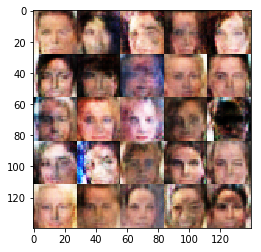

Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 2.6563
Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 0.3243... Generator Loss: 1.8638
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 2.8808
Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.7206
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7417


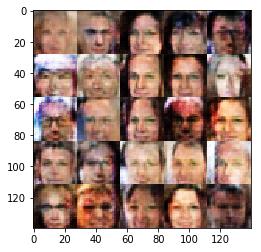

Epoch 1/1... Discriminator Loss: 1.6794... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.5970
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.9039


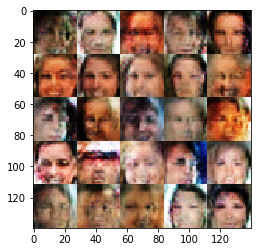

Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.2165
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.3830
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.5481
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 1.7063
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.4319
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.9787


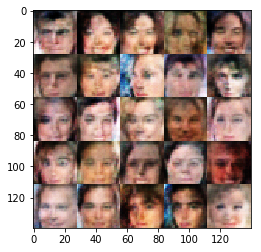

Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.3087
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.2099
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 0.9239


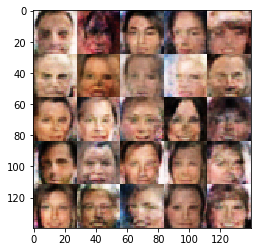

Epoch 1/1... Discriminator Loss: 1.7462... Generator Loss: 2.5465
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 2.1418
Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 2.6013
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.8525


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.